In [1]:
from flownet import FlowNetPET
from utils import XCAT3DDataset
from analysis_xcat import (plot_progress, load_phantoms, sample_output, apply_correction, 
                           evaluate_flows, calc_iou, plot_flow_pred, plot_orig_corr,
                           box_plot_flow_residuals, plot_metric_comparison_vert)

import configparser
import numpy as np
import torch
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

np.random.seed(1)
torch.manual_seed(1)

print('Using Torch version: %s' % (torch.__version__))

print('Using a %s device' % (device))

# Collect the command line arguments
model_name = 'fnp_1'

# Directories
cur_dir = ''
config_dir = os.path.join(cur_dir, 'configs/')
model_dir = os.path.join(cur_dir, 'models/')
progress_dir = os.path.join(cur_dir, 'progress/')
data_dir = os.path.join(cur_dir, 'data/')
    
# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']
print('\nCreating model: %s'%model_name)

print('\nConfiguration:')
for key_head in config.keys():
    if key_head=='DEFAULT':
        continue
    print('  %s' % key_head)
    for key in config[key_head].keys():
        print('    %s: %s'%(key, config[key_head][key]))

input_shape = eval(architecture_config['input_shape'])

# Check for pre-trained weights
model_filename =  os.path.join(model_dir,model_name+'.pth.tar')

# Construct Network
print('\nBuilding networks...')
model = FlowNetPET(architecture_config, device)
model.to(device)

# Display model architectures
print('\n\nARCHITECTURE:\n')
print(model.predictor)

# Create data loaders
data_file = os.path.join(data_dir,config['DATA']['data_file'])

val_dataset = XCAT3DDataset(data_file, dataset='val')
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1)

print('\nLoading saved model to continue training...')
# Load model info
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
losses = dict(checkpoint['losses'])

# Load model weights
model.load_state_dict(checkpoint['model'])

Using Torch version: 1.10.0+cu102
Using a cpu device

Creating model: fnp_1

Configuration:
  DATA
    data_file: xcat_training_set.h5
  TRAINING
    batchsize: 1
    learning_rate: 0.0003
    lr_decay_batch_iters: 8000
    lr_decay: 0.7
    total_batch_iters: 15000
    smooth_weight: 0.0
    res_weights: [1.0, 1.0, 1.0, 1.0]
    l2_weight: 0.0
    inv_weight: 1000.0
  ARCHITECTURE
    input_shape: [108, 152, 152]
    gauss_kernel_len: 15
    gauss_sigma: 0.9
    conv_filts: [16, 32, 64]
    conv_filt_lens: [3, 3, 3]
    conv_strides: [2, 2, 2]
    latent_filters: 256
    interp_mode: bilinear
  Notes
    comment: Original architecture

Building networks...


/home/jupyter-teaghan/.local/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The flow predictions will have sizes:
108 x 152 x 152
54 x 76 x 76
27 x 38 x 38
14 x 19 x 19


ARCHITECTURE:

FlowNetS(
  (conv1): Sequential(
    (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (3): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (3): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (3): ReLU(inplace=True)
  )
  (conv_latent): Sequential(
    (0): Conv3d(64, 256, ke

<All keys matched successfully>

Grond truth flow Distance: 0.005


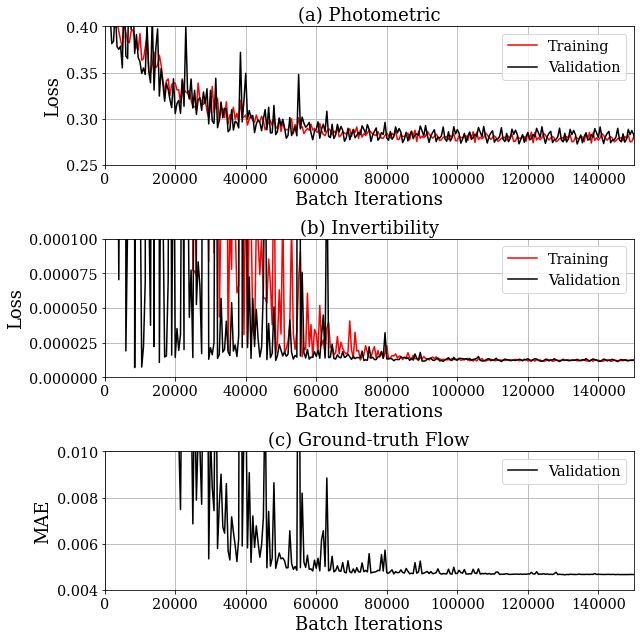

In [2]:
plot_progress(losses, y_lims=[(0.25,0.4),(0,1e-4),(4e-3,1e-2)], x_lim=(0,1.5e5),fontsize=18,
              savename='figures/fig12.png')



AP Expansion=6.0 mm
| Median (mm) | 25th - 75th - 95th Percentile Range (mm) |
|        0.58 |           0.23 - 1.39 - 4.69          |
Total counts enclosed in no motion VOI:
| No Motion | No Correction | Corrected |
|---------------------------------------|
|     83881 |         61130 |     80270 |
Signal to noise ratio of each VOI:
| No Motion | No Correction | Corrected |
|---------------------------------------|
|     14.04 |          2.31 |      6.27 |
Intersection over Union:
| No Correction | Corrected |
|---------------------------|
|          0.65 |      0.83 |


AP Expansion=8.0 mm
| Median (mm) | 25th - 75th - 95th Percentile Range (mm) |
|        0.77 |           0.29 - 1.83 - 5.87          |
Total counts enclosed in no motion VOI:
| No Motion | No Correction | Corrected |
|---------------------------------------|
|     83997 |         53936 |     81153 |
Signal to noise ratio of each VOI:
| No Motion | No Correction | Corrected |
|---------------------------------------|

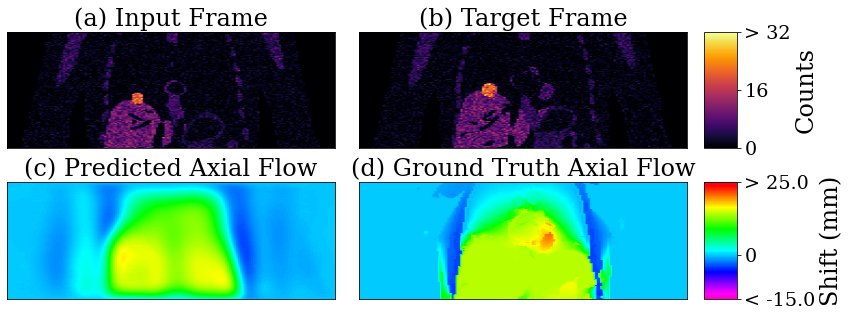

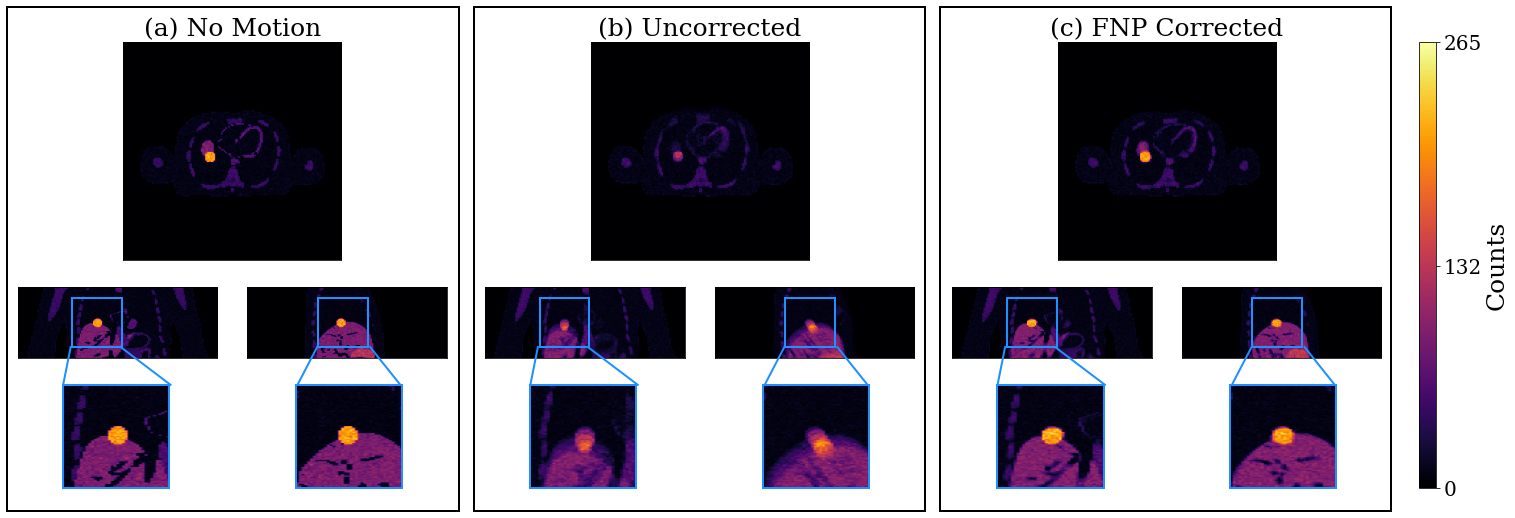

In [3]:
h5_fn = os.path.join(data_dir, 'xcat_frames_test_set.h5')
pat_num = 1
lesn_diameter=None
avg_counts = 9e6
n_samples = int(1.2e6)
pixel_width = 4 # mm
slice_width = 2 # mm
only_lsn_flow = False
AP_expansions = [0.6,0.8,1.0,1.2,1.4]

tot_counts_gt = []
tot_counts_orig = []
tot_counts_corr = []
snr_gt = []
snr_orig = []
snr_corr = []
iou_gt = np.ones((len(AP_expansions),))
iou_orig = []
iou_corr = []
med_resids = []

max_flow_diffs = []

for AP_expansion in AP_expansions:

    # Load images and flows
    tgt_img, inp_imgs, tumour_loc, gt_flows, gt_flow_masks  = load_phantoms(h5_fn, pat_num, 
                                                                            AP_expansion, lesn_diameter)

    # Create sample for ground truth
    gt_img = sample_output(tgt_img, int(n_samples*(len(inp_imgs)+1)))

    # Determine pixels including lesion
    tgt_lsn = (tgt_img==np.max(tgt_img)).astype(int)
    inp_lsn = (inp_imgs==np.max(tgt_img)).astype(int)
    gt_mask = np.copy(tgt_lsn)

    # Apply correction
    (orig_img, corr_img, pred_flows, orig_mask, 
     corr_mask, input_samples, target_sample) = apply_correction(model, inp_imgs, tgt_img, avg_counts, 
                                                                 n_samples, inp_lsn, tgt_lsn, device,
                                                                 val_dataset)

    # Calculate difference in flow predictions in mm
    if only_lsn_flow:
        flow_diffs = evaluate_flows(gt_img, pred_flows, gt_flows, 
                                    np.tile(np.expand_dims(tgt_lsn,(0,1)),(9,3,1,1,1)).astype(bool), 
                                    pixel_width, slice_width)
    else:
        flow_diffs = evaluate_flows(gt_img, pred_flows, gt_flows, gt_flow_masks, pixel_width, slice_width)

    # Select the flow with the largest true flow to compare
    max_flow_index = np.argmax(np.sum(np.abs(gt_flows), axis=(1,2,3,4)))

    flow_diff = np.copy(flow_diffs[max_flow_index])
    max_flow_diffs.append(flow_diff)
    med_resid = np.median(flow_diff) 
    med_resids.append(med_resid)

    print('\n\nAP Expansion=%0.1f mm' % (10*AP_expansion))

    print('| Median (mm) | 25th - 75th - 95th Percentile Range (mm) |')
    print('| %11.2f |           %0.2f - %0.2f - %0.2f          |' % (med_resid,
                                                            np.percentile(flow_diff, 25),
                                                            np.percentile(flow_diff, 75),
                                                            np.percentile(flow_diff, 95)))

    tot_counts_gt.append(np.sum(gt_img[gt_mask.astype(bool)]))
    tot_counts_orig.append(np.sum(orig_img[gt_mask.astype(bool)]))
    tot_counts_corr.append(np.sum(corr_img[gt_mask.astype(bool)]))
    print('Total counts enclosed in no motion VOI:')
    print('| No Motion | No Correction | Corrected |')
    print('|---------------------------------------|')
    print('| %9i | %13i | %9i |' % (tot_counts_gt[-1], tot_counts_orig[-1], tot_counts_corr[-1]))

    snr_gt.append(np.mean(gt_img[gt_mask.astype(bool)])/np.std(gt_img[gt_mask.astype(bool)]))
    snr_orig.append(np.mean(orig_img[gt_mask.astype(bool)])/np.std(orig_img[gt_mask.astype(bool)]))
    snr_corr.append(np.mean(corr_img[gt_mask.astype(bool)])/np.std(corr_img[gt_mask.astype(bool)]))
    #snr_orig.append(np.mean(orig_img[orig_mask.astype(bool)])/np.std(orig_img[orig_mask.astype(bool)]))
    #snr_corr.append(np.mean(corr_img[corr_mask.astype(bool)])/np.std(corr_img[corr_mask.astype(bool)]))
    print('Signal to noise ratio of each VOI:')
    print('| No Motion | No Correction | Corrected |')
    print('|---------------------------------------|')
    print('| %9.2f | %13.2f | %9.2f |' % (snr_gt[-1], snr_orig[-1], snr_corr[-1]))

    iou_orig.append(calc_iou(gt_mask, orig_mask))
    iou_corr.append(calc_iou(gt_mask, corr_mask))

    print('Intersection over Union:')
    print('| No Correction | Corrected |')
    print('|---------------------------|')
    print('| %13.2f | %9.2f |' % (iou_orig[-1], iou_corr[-1]))
    
    if AP_expansion==1.:
        plot_flow_pred(input_samples[max_flow_index], target_sample, 
               pred_flows[max_flow_index], gt_flows[max_flow_index], 
               fontsize=24, vmax_frac=.8, flow_min=-15, flow_max=25, 
               centre=tumour_loc, spacing=np.array([2, 4, 4]),
               show=False, savename='figures/fig3.png')
    
    if AP_expansion==1.4:
        plot_orig_corr(gt_img, orig_img, corr_img,
                     vmax_frac=1,
                     fontsize=25, centre=tumour_loc, lesn_diameter=25,
                     show=False, savename='figures/fig5.png')

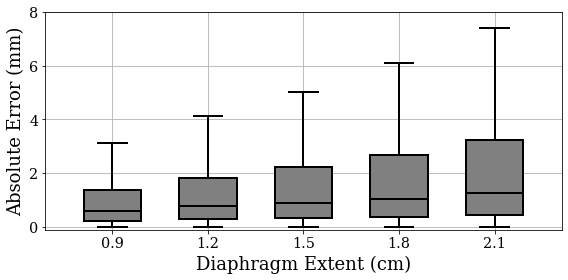

In [5]:
box_plot_flow_residuals(np.round(np.array(AP_expansions)*1.5,1), max_flow_diffs, 
                           y_lims=(-0.1,8), fontsize=18, 
                           x_label='Diaphragm Extent (cm)', 
                        savename='figures/fig4.png')

Residual Imporvements:
IOU:  [53. 54. 51. 51. 52.]
IOU (avg):  52.0
Counts:  [84. 91. 90. 94. 92.]
Counts (avg):  90.0
COV:  [76. 82. 72. 75. 75.]
COV (avg):  76.0


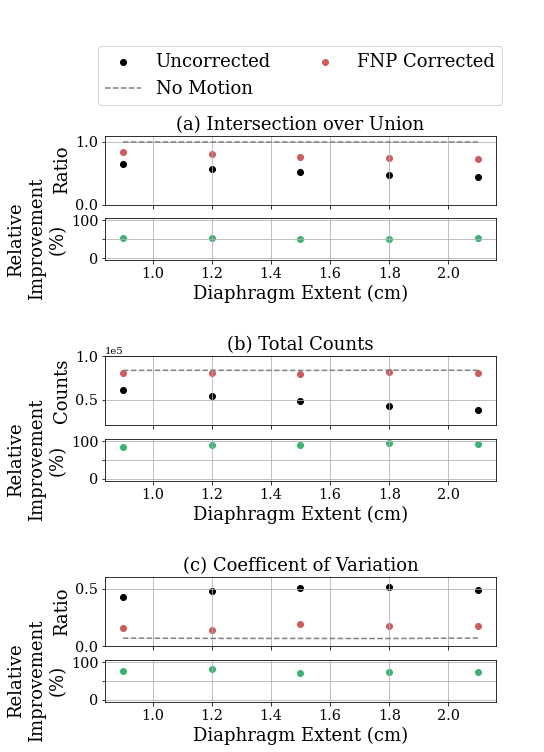

In [6]:
plot_metric_comparison_vert(np.array(AP_expansions)*1.5, tot_counts_gt, 
                           tot_counts_orig, tot_counts_corr, 
                           snr_gt, snr_orig, snr_corr, 
                           iou_orig, iou_corr,
                           y_lims=[(0,1.1),(2e4,1e5),(0,0.6)], fontsize=18, cov=True,
                           x_label='Diaphragm Extent (cm)', 
                       savename='figures/fig6.png')